In [1]:
using Distributions
using KernelDensity
using Printf
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

# Wald's method for log RR

safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

function pvalue_rr_wald_onesided(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    cdf(Normal(0, 1), safediv(logRRhat - log(ρ), SEhat_logRRhat))
end

# score method for RR (使わない)

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

# ((a-Δ)/(a-Δ+b))/((c+Δ)/(c+Δ+d)) = ρ if Δ = Delta(a, b, c, d; ρ)
function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_score(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_score(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_score(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

# Bayesian method

_ecdf(A, x) = count(≤(x), A) / length(A)

function posterior_pdf_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    ik = InterpKDE(kde(RR))
    pdf_rr(x) = pdf(ik, x)
    pdf_rr
end

function posterior_pvalue_function_rr_eti(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    pvalue_rr_eti(x) = (p = _ecdf(RR, x); min(2p, 2(1-p)))
    pvalue_rr_eti
end

function posterior_onesided_pvalue_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    onesided_pvalue_rr(x) = 1 - _ecdf(RR, x)
    onesided_pvalue_rr
end

function posterior_credint_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    credint_rr(α=0.05) = [quantile(RR, α/2), quantile(RR, 1-α/2)]
    credint_rr
end

# HDI version (使わない)

function posterior_pvalue_function_rr_hdi(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    logRR = log.(sort(P ./ Q))
    ik = InterpKDE(kde(logRR))
    pdf_logrr(x) = pdf(ik, x)
    function pvalue_rr_hdi(ρ)
        pdf_logrr_logρ = pdf_logrr(log(ρ))
        i1 = findfirst(x -> pdf_logrr(x) > pdf_logrr_logρ, logRR)
        i2 = findlast(x -> pdf_logrr(x) > pdf_logrr_logρ, logRR)
        1 - (i2-i1)/L
    end
    pvalue_rr_hdi
end

posterior_pvalue_function_rr_hdi (generic function with 1 method)

In [2]:
function plot_ABtest(a, b, c, d;
        ρmin=0.5, ρmax=1.8, ρtick=0.1:0.1:3,
        prior1=(1, 1), prior2=(1, 1), correct_by_prior=true,
    )
    if correct_by_prior
        (aa, bb) = (a-1, b-1) .+ prior1
        (cc, dd) = (c-1, d-1) .+ prior2
    else
        aa, bb, cc, dd = a, b, c, d
    end
    
    @printf("Wald     95%% confident interval of success rate ratio = [%.3f, %.3f]\n",
        confint_rr_wald(aa, bb, cc, dd)...)
    #@printf("score    95%% confident interval of success rate ratio = [%.3f, %.3f]\n",
    #    confint_rr_score(aa, bb, cc, dd)...)
    @printf("Bayesian 95%% credible  interval of success rate ratio = [%.3f, %.3f]\n",
        posterior_credint_function_rr(a, b, c, d; prior1, prior2)()...)
    println()

    f1(ρ) = pvalue_rr_wald(aa, bb, cc, dd; ρ)
    g1 = posterior_pvalue_function_rr_eti(a, b, c, d; prior1, prior2)
    #f2(ρ) = pvalue_rr_score(aa, bb, cc, dd; ρ)
    #g2 = posterior_pvalue_function_rr_hdi(a, b, c, d; prior1, prior2)

    P = plot(f1, ρmin, ρmax; label="Wald method")
    plot!(g1, ρmin, ρmax; label="Bayesian method (ETI)", c=2, ls=:dash)
    #plot!(f2, ρmin, ρmax; label="score method", c=3, ls=:dot)
    #plot!(g2, ρmin, ρmax; label="Bayesian (HDI)", c=4, ls=:dashdot)
    plot!(xtick=ρtick, ytick=0:0.05:1)
    plot!(xguide="hypothetical success rate ratio ρ",
        yguide="P-value", guidefontsize=10)
    title!("frequentist and Bayesian\nP-value functions of success rate ratio",
        titlefontsize=11)

    h = posterior_pdf_rr(a, b, c, d; prior1, prior2)
    Q = plot(h, ρmin, ρmax; label="", c=2)
    plot!(xtick=ρtick)
    plot!(xguide="hypothetical success rate ratio ρ",
        yguide="probability density", guidefontsize=10)
    title!("posterior density function of success rate ratio",
        titlefontsize=11)

    F(ρ) = pvalue_rr_wald_onesided(aa, bb, cc, dd; ρ)
    G = posterior_onesided_pvalue_function_rr(a, b, c, d; prior1, prior2)

    R = plot(F, ρmin, ρmax; label="Wald method\none-sided P-value of SRR≥ρ")
    plot!(G, ρmin, ρmax; label="Bayesian method\nposterior probability of SRR≥ρ", c=2, ls=:dash)
    plot!(xtick=ρtick, ytick=0:0.05:1)
    plot!(xguide="hypothetical success rate ratio ρ",
        yguide="one-sided P-value", guidefontsize=10)
    title!("frequentist and Bayesian\none-sided P-value functions of success rate ratio",
        titlefontsize=11)

    plot(P, R, Q; size=(700, 1000), layout=(3, 1))
    plot!(leftmargin=10Plots.mm, tickfontsize=7, legendfontsize=10)
    plot!(plot_title="data=[$a $b; $c $d]\nprior1=Beta$prior1, prior2=Beta$prior2, correct_by_prior=$correct_by_prior",
        plot_titlefontsize=11)
end

plot_ABtest (generic function with 1 method)

https://x.com/nozomimaki2/status/1869143242585129275

(See also https://x.com/search?q=Greenland%20McElreath%20from%3Agenkuroki&src=typed_query&f=live)

Wald     95% confident interval of success rate ratio = [0.855, 1.392]
Bayesian 95% credible  interval of success rate ratio = [0.855, 1.391]



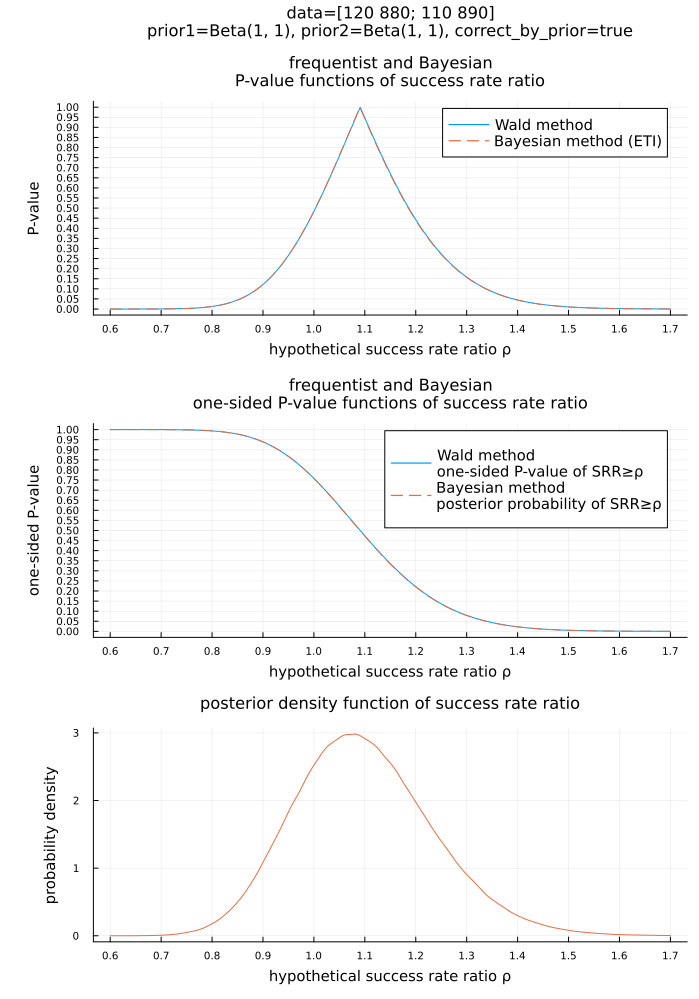

In [3]:
a, b, c, d = 120, 1000-120, 110, 1000-110
ρmin, ρmax = 0.6, 1.7
ρtick = 0.1:0.1:3
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick)

Wald     95% confident interval of success rate ratio = [0.855, 1.392]
Bayesian 95% credible  interval of success rate ratio = [0.856, 1.391]



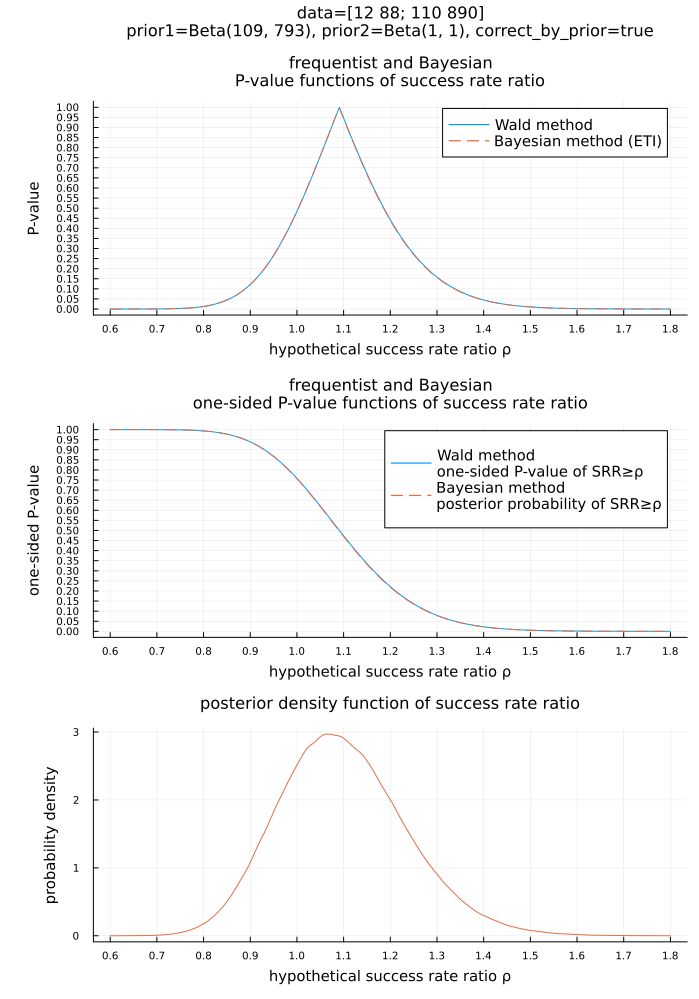

In [4]:
a, b, c, d = 12, 100-12, 110, 1000-110
ρmin, ρmax = 0.6, 1.8
ρtick = 0:0.1:10
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick, 
    prior1=(1+120-a, 1+1000-120-b), correct_by_prior=true)

Wald     95% confident interval of success rate ratio = [0.624, 1.908]
Bayesian 95% credible  interval of success rate ratio = [0.622, 1.862]



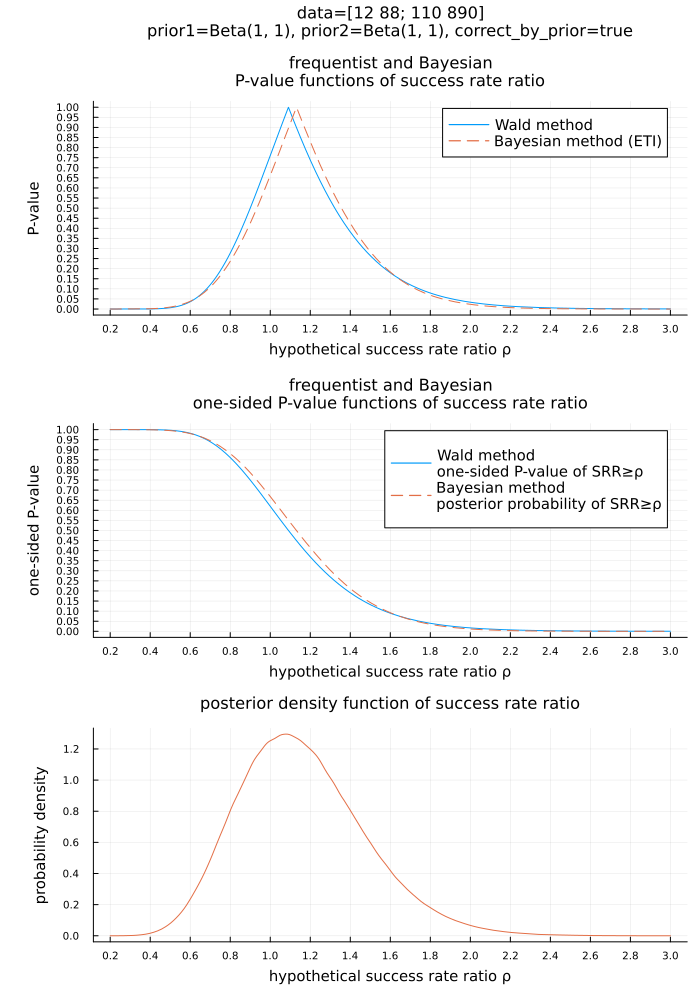

In [5]:
a, b, c, d = 12, 100-12, 110, 1000-110
ρmin, ρmax = 0.2, 3.0
ρtick = 0.2:0.2:3
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick)

Wald     95% confident interval of success rate ratio = [0.505, 2.356]
Bayesian 95% credible  interval of success rate ratio = [0.513, 2.321]



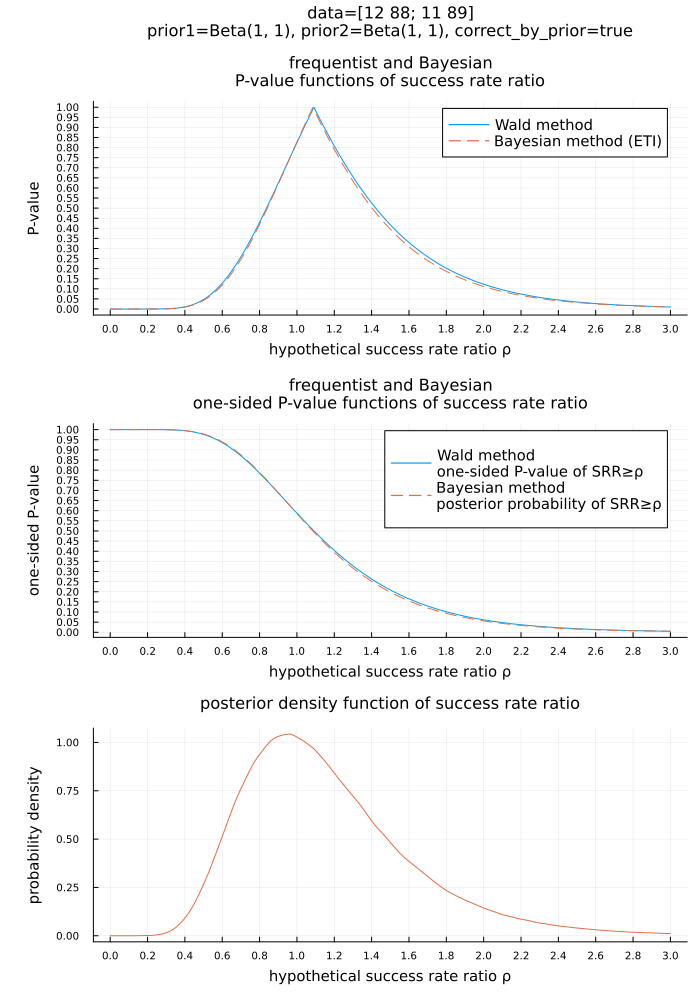

In [6]:
a, b, c, d = 12, 100-12, 11, 100-11
ρmin, ρmax = 0, 3
ρtick = 0:0.2:3
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick)

Wald     95% confident interval of success rate ratio = [0.520, 6.359]
Bayesian 95% credible  interval of success rate ratio = [0.537, 4.793]



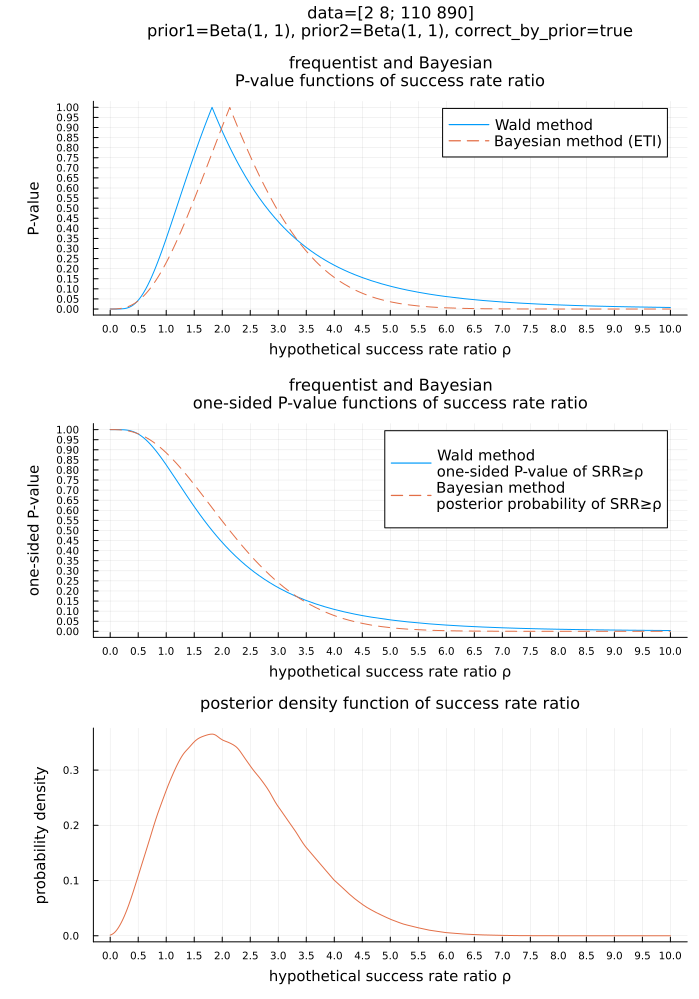

In [7]:
a, b, c, d = 2, 10-2, 110, 1000-110
ρmin, ρmax = 0, 10
ρtick = 0:0.5:10
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick)

Wald     95% confident interval of success rate ratio = [0.014, 0.599]
Bayesian 95% credible  interval of success rate ratio = [0.023, 0.475]



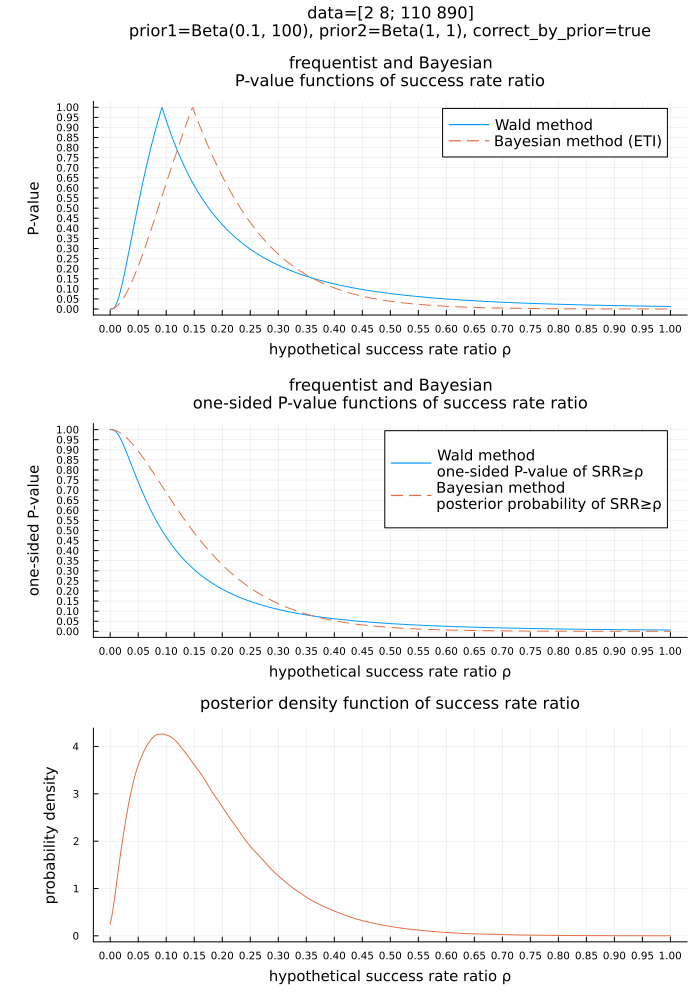

In [8]:
a, b, c, d = 2, 10-2, 110, 1000-110
ρmin, ρmax = 0, 1
ρtick = 0:0.05:1.0
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick, prior1=(0.1, 100), correct_by_prior=true)

Wald     95% confident interval of success rate ratio = [0.473, 3.928]
Bayesian 95% credible  interval of success rate ratio = [0.486, 3.371]



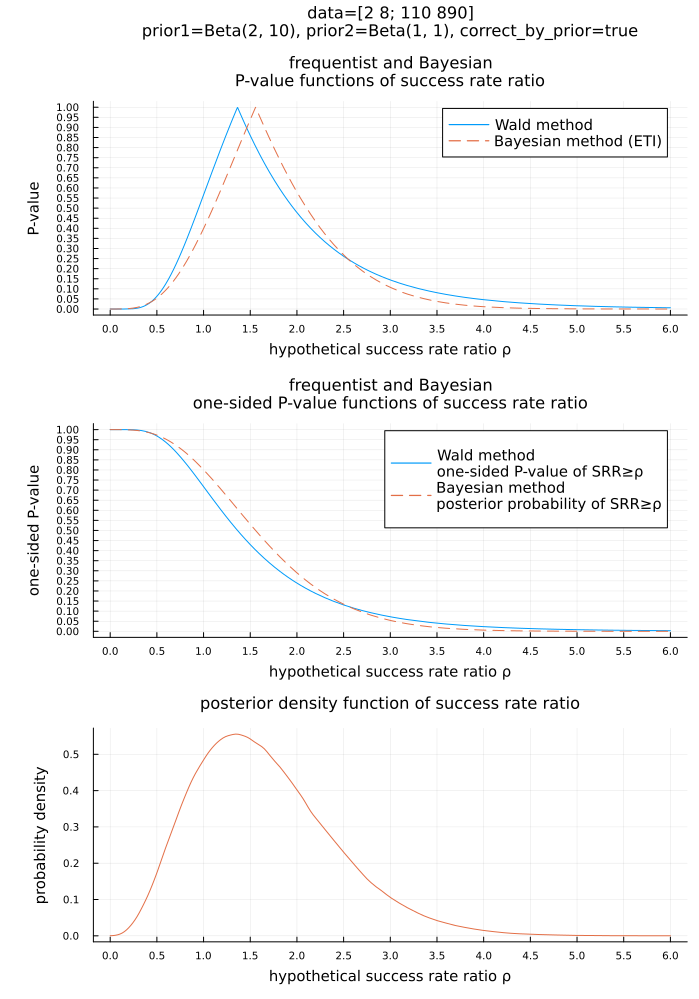

In [9]:
a, b, c, d = 2, 10-2, 110, 1000-110
ρmin, ρmax = 0, 6
ρtick = 0:0.5:6
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick, prior1=(1+1, 1+9), correct_by_prior=true)

Wald     95% confident interval of success rate ratio = [0.473, 3.928]
Bayesian 95% credible  interval of success rate ratio = [0.486, 3.368]



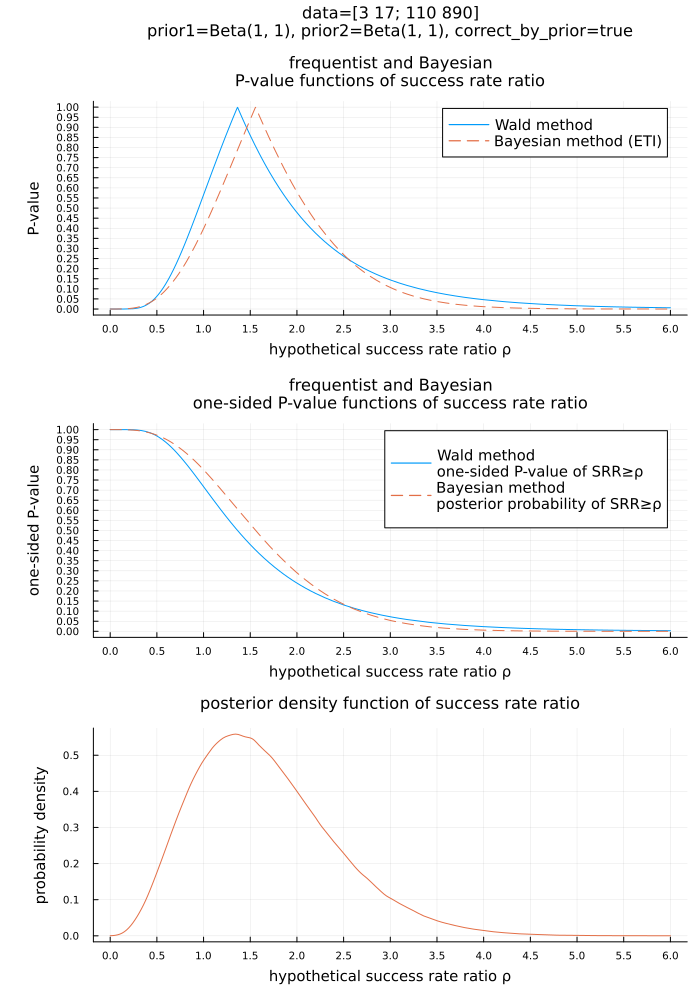

In [10]:
a, b, c, d = 3, 20-3, 110, 1000-110
ρmin, ρmax = 0, 6
ρtick = 0:0.5:6
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick, prior1=(1, 1), correct_by_prior=true)